# HW#1: Extreme Rainfall Deficit in Singapore 

```{admonition} Objectives
:class: tip

This homework will help you gain a better understanding in terms of the ways how to:
* Fit Generalized Extreme Value (GEV) distribution 
* Estimate the return level of extreme rainfall deficit

Happy coding!
```

```{admonition} Submission Guide

Deadline: **Sunday 11:59 pm, 2nd November 2025** 
(Note: Late submissions will not be accepted). 

Please upload your solutions to [Canvas](https://canvas.nus.edu.sg/courses/77993/assignments) in a Jupyter Notebook format with the name "Homework1_StudentID.ipynb". Make sure to write down your student ID and full name in the cell below. 

For any questions, feel free to contact Prof. Xiaogang HE ([hexg@nus.edu.sg](mailto:hexg@nus.edu.sg)), Kewei ZHANG ([kewei_zhang@u.nus.edu](mailto:kewei_zhang@u.nus.edu)) or Yifan LU ([yifan_lu@u.nus.edu](mailto:yifan_lu@u.nus.edu)).

```

In [1]:
## Fill your student ID and full name below.

# Student ID:
# Full name:

**Data**:
You will need to use the historical (1981-2020) daily total rainfall at Singapore's Changi station for this homework. 
You can create a DataFrame using Pandas by reading file "../../assets/data/Changi_daily_rainfall.csv".

## Q1: Calculate daily rainfall statistics (10 marks)

Calculate the following statistics for daily rainfall during DJF (**D**ecember-**J**anuary-**F**ebruary): (i) mean, (ii) variance, (iii) skewness, and (iv) kurtosis.

Hint: 
- You can filter the daily rainfall time series for DJF using Pandas' boolean filtering method. Details on filtering values can be found in the [Pandas tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/pandas-basic.html).
- DJF spans across two calendar years. Make sure you only include complete DJF seasons. For the period 1891 to 2020, this results in 39 complete DJF seasons, from DJF 1981-1982 to DJF 2019-2020.

In [2]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.stats import genextreme as gev

In [4]:
rain = pd.read_csv('../assets/data/Changi_daily_rainfall.csv', index_col = 0, header = 0, parse_dates = True)
display(rain.head(10))

,Daily Rainfall Total (mm)
Date,
1981-01-01,0.0
1981-01-02,0.0
1981-01-03,0.0
1981-01-04,0.0
1981-01-05,0.0
1981-01-06,0.3
1981-01-07,51.4
1981-01-08,0.0
1981-01-09,4.4


In [5]:
# Filter daily rainfall for December-January-February (DJF)
DJF_rain = rain.loc[(rain.index.month < 3) | (rain.index.month > 11)]
# Select the complete DJF periods
DJF_rain = DJF_rain.loc['19811201':'20200301']
# Calculate the following statistics for daily rainfall during DJF: (i) mean; (ii) variance; (iii) skewness; and (iv) kurtosis.
DJF_rain_stats = pd.Series([
                            DJF_rain.mean().values[0], 
                            DJF_rain.var().values[0], 
                            DJF_rain.skew().values[0], 
                            DJF_rain.kurtosis().values[0]],
                            index=['Mean', 'Variance', 'Skewness', 'Kurtosis']
                            )
display(DJF_rain_stats)

Mean          7.203409
Variance    340.698022
Skewness      4.909512
Kurtosis     33.412606
dtype: float64

In [6]:
# Add 'Year' column to denote the year of the days
DJF_rain['Year'] = np.where(DJF_rain.index.month==12, DJF_rain.index.year.values, DJF_rain.index.year.values-1)
# Group by DJF season year
DJF_rain_grouped = DJF_rain.groupby('Year')['Daily Rainfall Total (mm)']

# Compute each statistic explicitly
DJF_stats = pd.DataFrame({
    'mean': DJF_rain_grouped.mean(),
    'variance': DJF_rain_grouped.var(),
    'skew': DJF_rain_grouped.skew(),
    'fisher_kurtosis': DJF_rain_grouped.apply(pd.Series.kurt),
    'pearson_kurtosis': DJF_rain_grouped.apply(pd.Series.kurt) + 3
})

DJF_stats

,mean,variance,skew,fisher_kurtosis,pearson_kurtosis
Year,,,,,
1981,5.803333,177.008865,3.031608,9.601951,12.601951
1982,8.285556,323.570688,3.226329,12.567868,15.567868
1983,12.002198,782.667106,3.819583,16.588514,19.588514
1984,5.197778,133.260220,3.113894,10.226615,13.226615
1985,7.500000,298.638427,3.266719,11.947807,14.947807
1986,11.363333,590.704596,3.260409,12.065640,15.065640
1987,5.147253,137.969409,3.144627,11.282675,14.282675
1988,3.388889,97.620325,3.522151,12.658900,15.658900
1989,3.902222,116.119995,4.447478,22.850849,25.850849


## Q2: Preprocess daily rainfall data (20 marks)

Find the seasonal maximum rainfall deficit for DJF, based on the 15-day centered moving average rainfall deficit.

To do this: 
- Compute the 15-day centered moving average of daily rainfall. (10 marks)
- Calculate the daily rainfall deficit by subtracting the 15-day moving average rainfall from the mean rainfall calculated in Q1. This will be used in Q6. (5 marks)
- For each DJF season, take the maximum deficit (one value per season). This yields 39 seasonal maxima that are used for Q3–Q5 (block-maxima approach). (5 marks)

In [7]:
# Calculate the 15-day moving average for each year
DJF_rain_a = DJF_rain.groupby(['Year']).rolling(15, center=True).mean()
DJF_rain_a = DJF_rain_a.dropna(subset='Daily Rainfall Total (mm)')
DJF_rain_a.rename(columns={'Daily Rainfall Total (mm)': '15-day Moving Average Rainfall (mm)'}, inplace=True)

In [8]:
# Method 1 — Single mean across all DJF data
DJF_rain_def1 = DJF_rain['Daily Rainfall Total (mm)'].mean() - DJF_rain_a.iloc[:, 0]
DJF_rain_def1 = DJF_rain_def1.to_frame('15-day Moving Average Rainfall Deficit (mm)')

# Method 2 — Year-specific mean from DJF_stats
DJF_rain_def2 = DJF_stats['mean'].rsub(DJF_rain_a.iloc[:, 0], level='Year')
DJF_rain_def2 = DJF_rain_def2.to_frame('15-day Moving Average Rainfall Deficit (mm)')

# Change method here
DJF_rain_def = DJF_rain_def1
display(DJF_rain_def)

15-day Moving Average Rainfall Deficit (mm)
Year Date                                                   
1981 1981-12-08                                    -7.509924
     1981-12-09                                   -11.056591
     1981-12-10                                   -12.843258
     1981-12-11                                   -14.963258
     1981-12-12                                   -12.329924
...                                                      ...
2019 2020-02-18                                     3.843409
     2020-02-19                                     5.430076
     2020-02-20                                     5.430076
     2020-02-21                                     5.430076
     2020-02-22                                     5.430076

[2974 rows x 1 columns]

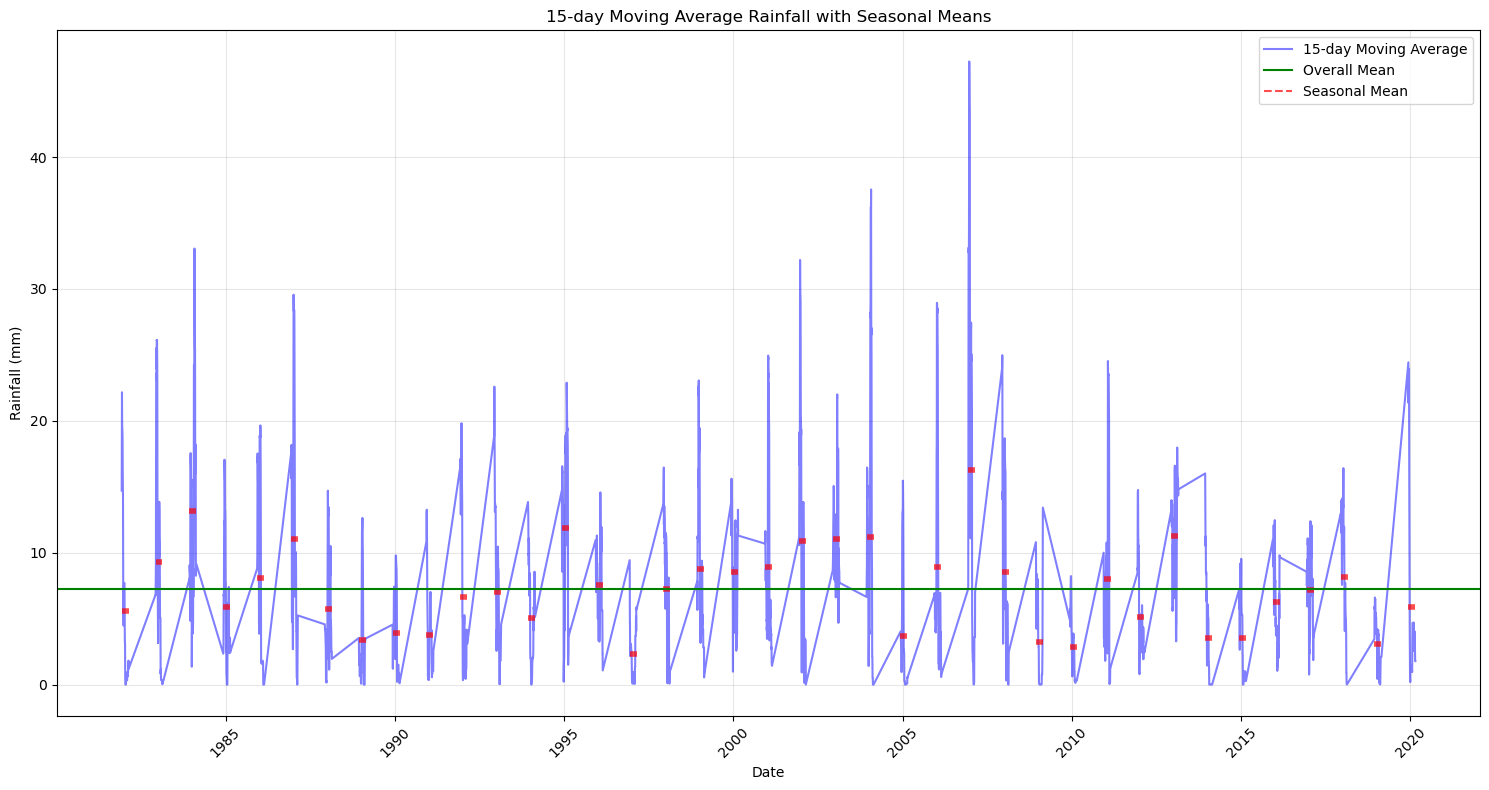

In [9]:
# Create a figure with appropriate size
plt.figure(figsize=(15, 8))

# Plot the original time series
plt.plot(DJF_rain_a.index.get_level_values('Date'), 
         DJF_rain_a['15-day Moving Average Rainfall (mm)'], 
         'b-', alpha=0.5, label='15-day Moving Average')

# Calculate and plot annual mean
annual_mean = DJF_rain_a.groupby(level='Year')['15-day Moving Average Rainfall (mm)'].mean()
for year in annual_mean.index:
    year_data = DJF_rain_a.xs(year, level='Year')
    start_time = year_data.index[0]
    end_time = year_data.index[-1]
    plt.hlines(y=annual_mean[year], 
               xmin=start_time,
               xmax=end_time,
               color='r', linestyle='--', alpha=0.7, linewidth=4)

# Calculate the overall mean
overall_mean = DJF_rain_a['15-day Moving Average Rainfall (mm)'].mean()
plt.axhline(y=overall_mean, color='g', linestyle='-', label='Overall Mean')

plt.title('15-day Moving Average Rainfall with Seasonal Means')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')

# Create custom legend with correct line styles
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='b', linestyle='-', alpha=0.5),
    Line2D([0], [0], color='g', linestyle='-'),
    Line2D([0], [0], color='r', linestyle='--', alpha=0.7)
]
plt.legend(custom_lines, ['15-day Moving Average', 'Overall Mean', 'Seasonal Mean'])

plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Calculate the maximum deficit for each year
DJF_max_def = pd.DataFrame(DJF_rain_def['15-day Moving Average Rainfall Deficit (mm)'].groupby('Year').max())
DJF_max_def.columns = ['DJF Maximum Rainfall Deficit (mm)']
DJF_max_def

,DJF Maximum Rainfall Deficit (mm)
Year,
1981,7.203409
1982,7.170076
1983,5.850076
1984,7.203409
1985,7.203409
1986,7.203409
1987,7.050076
1988,7.203409
1989,7.103409


## Q3: Fit the GEV distribution (20 marks)

Fit a GEV distribution to the time series of seasonal maximum rainfall deficits. To do this, estimate the GEV parameters using (i) Maximum Likelihood and (ii) L-Moments, respectively. (Details on fitting a GEV distribution can be found in the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html))

In [11]:
# Fit the distribution using MLE
cMLE, locMLE, scaleMLE = gev.fit(DJF_max_def, method = "MLE")
MLEGEV = gev(cMLE, loc = locMLE, scale = scaleMLE) 

In [12]:
# Calculate L-moments based on samples
def samlmom3(sample):
    """
    samlmom3 returns the first three L-moments of samples
    sample is the 1-d array
    n is the total number of the samples, j is the j_th sample
    """
    n = len(sample)
    sample = np.sort(sample.reshape(n))[::-1]
    b0 = np.mean(sample)
    b1 = np.array([(n - j - 1) * sample[j] / n / (n - 1)
                   for j in range(n)]).sum()
    b2 = np.array([(n - j - 1) * (n - j - 2) * sample[j] / n / (n - 1) / (n - 2)
                   for j in range(n - 1)]).sum()
    lmom1 = b0
    lmom2 = 2 * b1 - b0
    lmom3 = 6 * (b2 - b1) + b0

    return lmom1, lmom2, lmom3

def pargev_fsolve(lmom):
    """
    pargev_fsolve estimates the parameters of the Generalized Extreme Value 
    distribution given the L-moments of samples
    """
    lmom_ratios = [lmom[0], lmom[1], lmom[2] / lmom[1]]
    f = lambda x, t: 2 * (1 - 3**(-x)) / (1 - 2**(-x)) - 3 - t
    G = fsolve(f, 0.01, lmom_ratios[2])[0]
    para3 = G
    GAM = math.gamma(1 + G)
    para2 = lmom_ratios[1] * G / (GAM * (1 - 2**-G))
    para1 = lmom_ratios[0] - para2 * (1 - GAM) / G
    return para1, para2, para3

In [13]:
# Fit the distribution using LMM
LMM = samlmom3(DJF_max_def.values)
locLMM, scaleLMM, cLMM = pargev_fsolve(LMM)
LMMGEV = gev(cLMM, loc=locLMM, scale=scaleLMM) 

In [14]:
print('Parameters fitted by Maximum Likelihood: shape={:.3f}, loc={:.3f}, scale={:.3f}\n'
      .format(cMLE, locMLE, scaleMLE,))
print('Parameters fitted by L-Moments: shape={:.3f}, loc={:.3f}, scale={:.3f}\n'
      .format(cLMM, locLMM, scaleLMM))

Parameters fitted by Maximum Likelihood: shape=1.700, loc=6.651, scale=0.940

Parameters fitted by L-Moments: shape=2.065, loc=6.993, scale=0.472



## Q4: Estimate the return level of the extreme events (20 marks)

Using the GEV parameters estimated with L-Moments in Q2, estimate the rainfall deficit for events with return periods of 10 years, 50 years, 100 years, and 1000 years.

In [15]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [16]:
T = np.arange(2, 1001)
rainDef_lmm = LMMGEV.ppf(1 - 1.0 / T)
rainDef_lmm = pd.DataFrame(rainDef_lmm, index = T, 
                      columns = ["DJF Maximum Rainfall Deficit (mm)"])
rainDef_lmm.index.name = "Return period"

display(rainDef_lmm.loc[[10, 50, 100, 1000]])

,DJF Maximum Rainfall Deficit (mm)
Return period,
10,7.219571
50,7.221692
100,7.221747
1000,7.221764


## Q5: Test the goodness-of-fit (20 marks)

In this task, you will compare how different distributions fit the same dataset and interpret the results using both statistical analyses. 
- Repeat the distribution fitting as in Q2, but this time using a [normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) and the Maximum Likelihood method. (5 marks)
- Use the Kolmogorov-Smirnov (KS) test to evaluate the goodness-of-fit for both the normal distribution and the GEV distribution you obtained in Q2. (Details on the KS test can be found in the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html)) (10 marks)
- Based on the KS test results, discuss how well each distribution (Normal and GEV) fits the data. (5 marks)

**Bonus (5 marks):**
- Plot the CDF (Cumulative Distribution Function) to visually compare the fitted normal distribution, the GEV distribution from Q2, and the empirical distribution derived from the data. Compare the behavior of the two distributions at different return periods. Are the KS statistic results consistent with your observations from the CDF plot?


Hint: You can reuse the empirical distribution estimation and CDF plotting code from the [Scipy tutorial](https://xiaoganghe.github.io/python-climate-visuals/chapters/data-analytics/scipy-basic.html).

In [17]:
# Your solutions go here.
# using the + icon in the toolbar to add a cell.

In [18]:
# Fit the normal distribution using MLE
from scipy.stats import norm
locMLE, scaleMLE = norm.fit(DJF_max_def, method = "MLE")
MLEnorm = norm(loc = locMLE, scale = scaleMLE) 

In [19]:
from scipy.stats import kstest
GEVKS = kstest(DJF_max_def["DJF Maximum Rainfall Deficit (mm)"], MLEGEV.cdf)
print('Goodness-of-fit for GEV distribution: statisic is {:.3f}, pvalue is {:.3f}'.format(GEVKS.statistic, GEVKS.pvalue))
NORMKS = kstest(DJF_max_def["DJF Maximum Rainfall Deficit (mm)"], MLEnorm.cdf)
print('Goodness-of-fit for Normal dirstribution: statisic is {:.3f}, pvalue is {:.3f}'.format(NORMKS.statistic, NORMKS.pvalue))


Goodness-of-fit for GEV distribution: statisic is 0.333, pvalue is 0.000
Goodness-of-fit for Normal dirstribution: statisic is 0.307, pvalue is 0.001


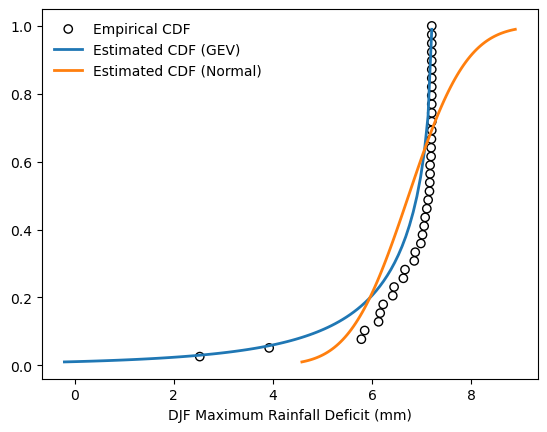

In [20]:
# Plot empirical CDF
plt.scatter(DJF_max_def.sort_values(by = ["DJF Maximum Rainfall Deficit (mm)"]),
            np.arange(1, DJF_max_def.size+1, dtype=float)/DJF_max_def.size,
            color = 'k', facecolors='none', label='Empirical CDF')

# Plot estimated PDF based on maximum likelihood method
bins = np.linspace(MLEGEV.ppf(0.01), MLEGEV.ppf(0.99), 100)
plt.plot(bins, MLEGEV.cdf(bins), 
        lw=2, label='Estimated CDF (GEV)')
# Plot estimated PDF based on the method of L-moments
bins = np.linspace(MLEnorm.ppf(0.01), MLEnorm.ppf(0.99), 100)
plt.plot(bins, MLEnorm.cdf(bins), 
         lw=2, label='Estimated CDF (Normal)')

plt.xlabel("DJF Maximum Rainfall Deficit (mm)")
plt.legend(loc='best', frameon=False)
plt.show()

In [21]:
# Both the GEV and normal distributions fail to accurately represent the data, as indicated by the extremely low KS test p-values.
# Nevertheless, the CDF comparison shows that the GEV distribution reproduces the observed shape more closely than the normal distribution.
# The statistical discrepancy for the GEV fit may arise because the MLE-based parameter estimation is insufficient for this dataset—potentially due to the limited sample size, temporal non-stationarity, or deviations from the GEV assumptions.
# In contrast, the normal distribution is clearly unsuitable, as it substantially overestimates the probability of large rainfall deficits (>7 mm).
# Overall, the GEV distribution provides a relatively better fit, but alternative estimation methods or distribution families should be explored to improve model performance.

## Q6: Simple peaks over threshold & histogram (10 marks)

Using the same 15-day centered moving-average deficit obtained in Q2:
- Compute the 95th percentile of the pooled DJF moving-average deficit and set this as the threshold 𝑢. Report the numeric value of 𝑢. (5 marks)
- Plot a histogram of the seasonal exceedance counts $𝑘_s$ in 39 years, with a 1-2 line caption describing the distribution. Day $i$ is considered as an exceedance if the deficit is larger than the threshold ($x_i-u>0$). (5 marks)

**Bonus (5 marks):**
- Show the polyline of the seasonal mean exceedance magnitude ($𝑦_s​ = \frac{1}{k_s}\sum_i \max\{x_i-u,0\}$) as well in the graph.

The threshold u (95th percentile) is: 7.17 mm


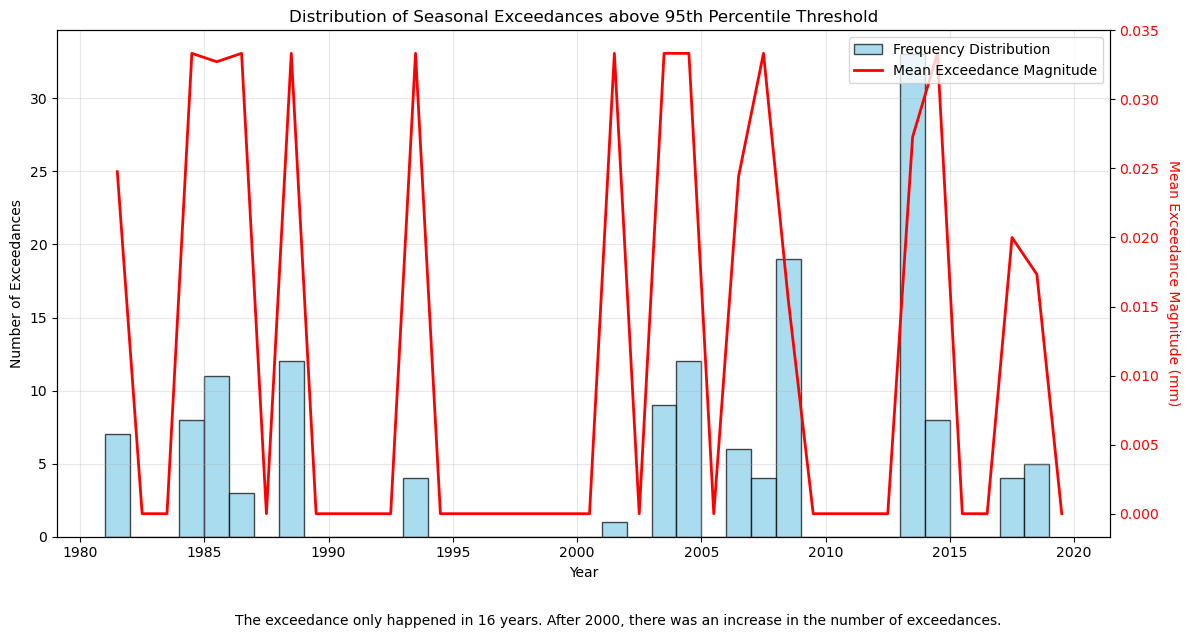

In [22]:
# Compute the 95th percentile of the pooled DJF moving-average deficit
u = np.percentile(DJF_rain_def['15-day Moving Average Rainfall Deficit (mm)'], 95)
print(f"The threshold u (95th percentile) is: {u:.2f} mm")

# Calculate exceedances for each year
exceedances_bool = DJF_rain_def['15-day Moving Average Rainfall Deficit (mm)'] > u
histogram_series = pd.Series(exceedances_bool.index.get_level_values('Year')[exceedances_bool == True])

# Calculate mean exceedance magnitude for each year (for bonus)
def calc_mean_exceedance(data, threshold):
    exceedances = data[data > threshold]
    if len(exceedances) > 0:
        return np.mean(exceedances - threshold)
    return 0

annual_mean_exceedance = DJF_rain_def['15-day Moving Average Rainfall Deficit (mm)'].groupby('Year').apply(
    lambda x: calc_mean_exceedance(x, u)
)

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot histogram of exceedance counts
n, bins, patches = ax1.hist(histogram_series, 
                             bins=range(1981, 2020), alpha=0.7, color='skyblue', edgecolor='black', 
                             label='Frequency Distribution', density=False)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Exceedances')
ax1.grid(True, alpha=0.3)

# Add mean exceedance magnitude line (bonus)
ax2 = ax1.twinx()
ax2.plot(annual_mean_exceedance.index + 0.5,
         annual_mean_exceedance, color='red', linewidth=2, 
         label='Mean Exceedance Magnitude')
ax2.set_ylabel('Mean Exceedance Magnitude (mm)', color='red', rotation=-90, labelpad=15)
ax2.tick_params(axis='y', labelcolor='red')
plt.title('Distribution of Seasonal Exceedances above 95th Percentile Threshold')

# Manually merge the legends from both axes
handles, labels = ax1.get_legend_handles_labels()  # Get legend items for ax1
handles2, labels2 = ax2.get_legend_handles_labels()  # Get legend items for ax2
plt.legend(handles=handles + handles2, labels=labels + labels2, loc='upper right')  # Combine and show legend

# Add caption
plt.figtext(0.2, -0.05, 
            'The exceedance only happened in 16 years. After 2000, there was an increase in the number of exceedances.',
            wrap=True, horizontalalignment='left', fontsize=10)

plt.tight_layout()

plt.show()